## Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Milk production data.csv to Milk production data.csv


In [5]:
milk_data = pd.read_csv(io.BytesIO(uploaded['Milk production data.csv']), index_col='Date', parse_dates=True)

In [7]:
#Showing pandas that we are taking monthly data
milk_data.index.freq='MS'

In [8]:
milk_data

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


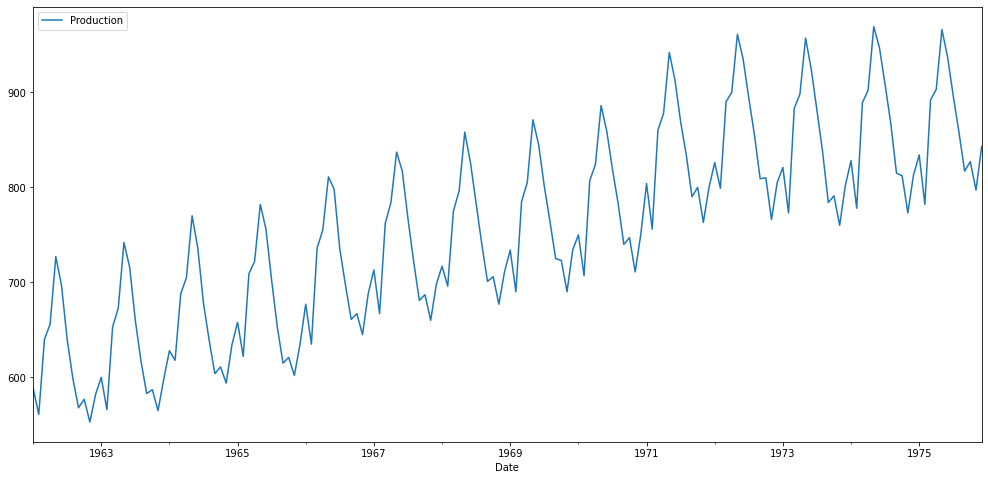

In [11]:
milk_data.plot(figsize=(17,8))

In [13]:
# This function will decompose the time series into different parts
from statsmodels.tsa.seasonal import seasonal_decompose

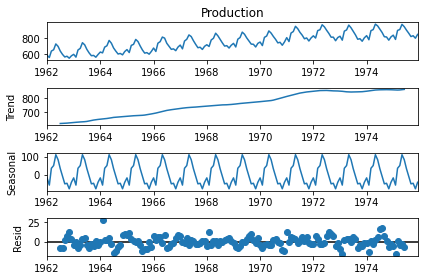

In [14]:
results = seasonal_decompose(milk_data['Production'])
results.plot();

# 1st one is the normal observed graph. 2nd is the trend graph which shows production is increasing
# 3rd shows just the seasonal production by removing the trend
# 4th graph shows the noise in the data 

In [15]:
len(milk_data)

168

In [16]:
# Now we are going to train the model. here the last 12 months are left from the training and be used for testing the model

train = milk_data.iloc[:156]
test = milk_data.iloc[156:]

In [17]:
# Here we will scale the data in the range of 0 to 1, so that the model won't get confused by the different ranges of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [18]:
milk_data.head(),milk_data.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [19]:
# Here first the scaler will study the data and then it will convert both train and test to standard scale using the transform function.
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
# define generator, here the generator works like we input 3 values and it will predict the 4th value
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
     

In [23]:
# Here it takes first 3 batches and it then predicts the 4th batch.
# Here if i give 1 instead of 0, it will take the 2nd, 3rd, and 4th values and predict the 5th value
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
     

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [24]:
X.shape

(1, 3, 1)

In [25]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [27]:
# Defining the model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
     

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fitting the model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 6ms/step - loss: 0.0393
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0226
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0172
Epoch 4/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0124
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0121
Epoch 6/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 7/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 8/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0070
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 10/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 11/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 12/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0040
Epoch 13/50
144/144 [====

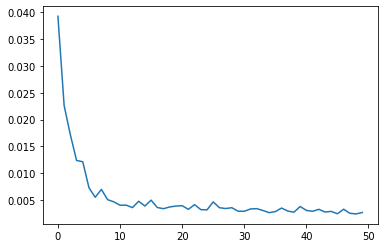

In [30]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
# Here we are taking everything as 12 batches. 
#So here we take the last 12 batches of our training set to predict the 1st 12 batches of the testing data
last_train_batch = scaled_train[-12:]


In [32]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [33]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 203ms/step


array([[0.58682173]], dtype=float32)

In [34]:
# Here is the orginal value v/s what our model predicted
scaled_test[0]

array([0.67548077])

In [42]:
# First we take an empty list of test predictions
test_predictions = []

# Here we take the last n values which is called as the current batch
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

test_predictions = scaler.inverse_transform(test_predictions)
test['Predicted'] = test_predictions

1/1 [==============================] - 0s 17ms/step


<ipython-input-42-2fdca59d6edc>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted'] = test_predictions


In [43]:
test_predictions

array([[797.11784172],
       [798.19810867],
       [856.34189606],
       [888.96049309],
       [924.66648102],
       [920.52716446],
       [893.93075752],
       [854.98570442],
       [814.86534309],
       [793.3718071 ],
       [775.21679115],
       [783.90980721]])

In [44]:
test.head()

,Production,Predicted
Date,,
1975-01-01,834,797.117842
1975-02-01,782,798.198109
1975-03-01,892,856.341896
1975-04-01,903,888.960493
1975-05-01,966,924.666481


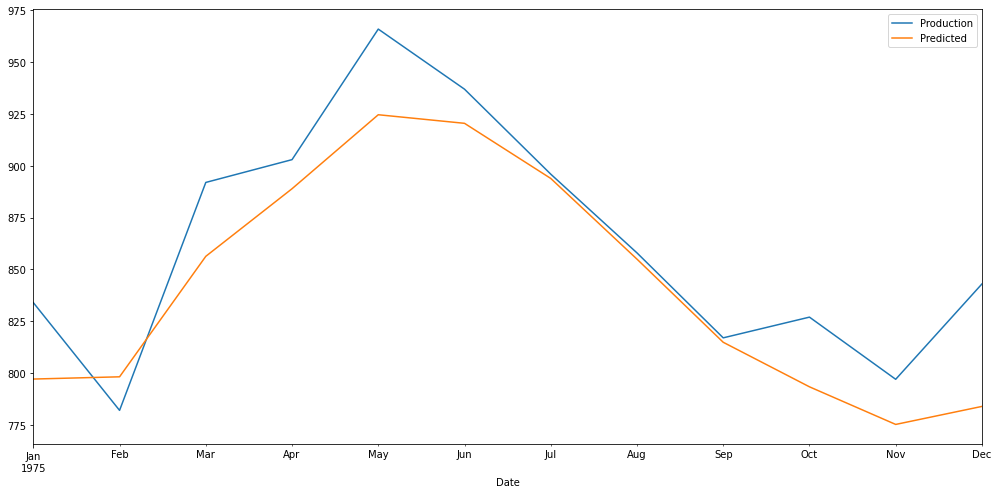

In [46]:
test.plot(figsize=(17,8))

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predicted']))
print(rmse)
     

29.13479233043841
